## TaiChung DE PV Forecast by SVR

Data from TaiChung DE PV plant, CWB WUQI weather.

Collect 2016/01/01-2017/12/31.

Time frequcy: 1 hour.

In [56]:
# import library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
# cross-validation iterator
from sklearn.model_selection import TimeSeriesSplit, train_test_split, cross_val_score
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
# quick look data
data = pd.read_csv('data\\Taichung_Power_Sunshine_Irradiance.csv', parse_dates=['Date'], index_col='Date')
print(data.head(12))
print(data.describe())

                     power(KWH)_replaced  SunShine  GloblRad  Solar Irradiance
Date                                                                          
2016-01-01 01:00:00                  0.0       0.0      0.00          0.000000
2016-01-01 02:00:00                  0.0       0.0      0.00          0.000000
2016-01-01 03:00:00                  0.0       0.0      0.00          0.000000
2016-01-01 04:00:00                  0.0       0.0      0.00          0.000000
2016-01-01 05:00:00                  0.0       0.0      0.00          0.000000
2016-01-01 06:00:00                  0.0       0.0      0.00          4.164694
2016-01-01 07:00:00                  0.0       0.0      0.00        107.933226
2016-01-01 08:00:00                146.0       0.7      0.30        305.363132
2016-01-01 09:00:00                444.0       1.0      0.89        477.315428
2016-01-01 10:00:00                680.0       1.0      1.52        621.637047
2016-01-01 11:00:00                892.0       1.0  

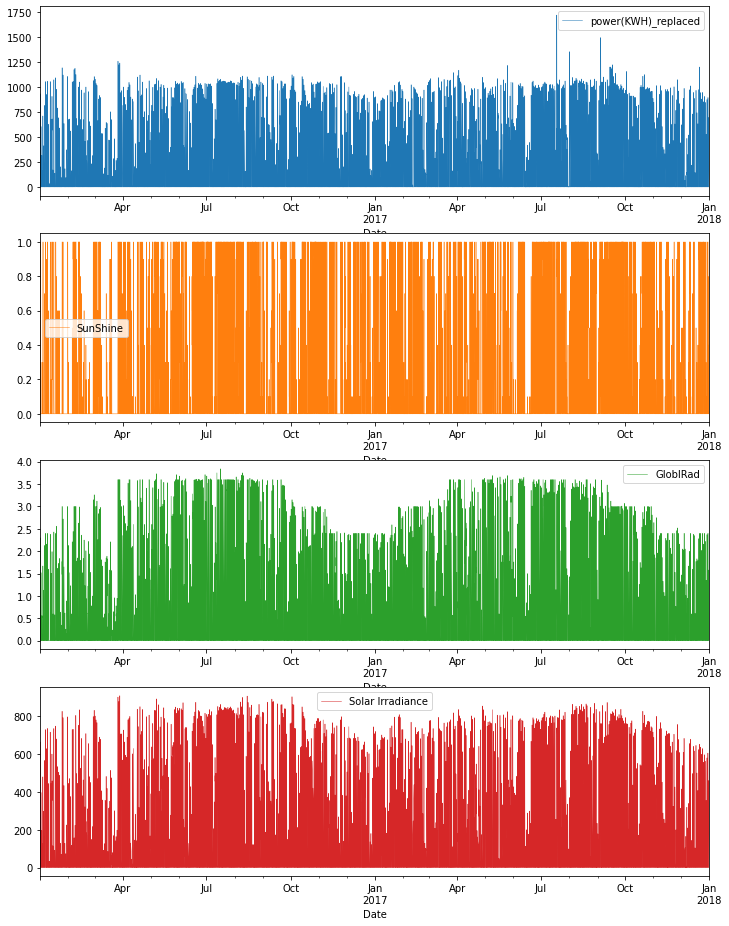

In [3]:
# visualizing data
data.plot(subplots=True, linewidth=0.5, layout=(4, 1), figsize=(12, 16),
          sharex=False, sharey=False)
plt.show()

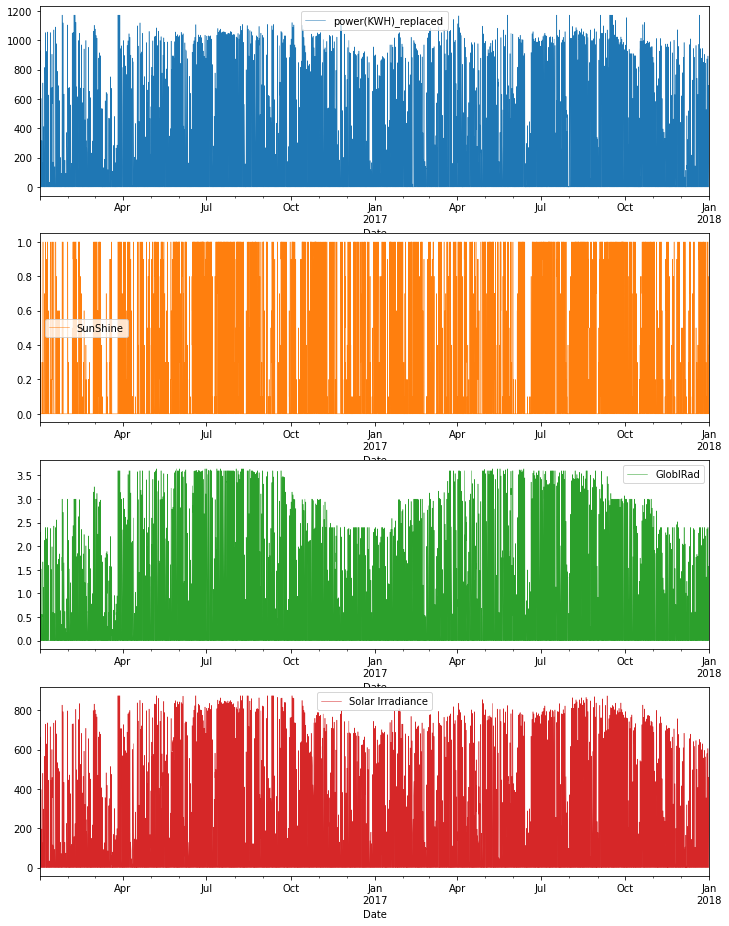

In [4]:
# replace outlier
def replace_outlier(series):
    series_mean = series.mean()
    series_std = series.std()
    upper = series_mean + 3 * series_std 
    series_new = np.where(series > upper, upper, series)
    return series_new

for col in data.columns:
    data[col] = replace_outlier(data[col])

# visualizing data
data.plot(subplots=True, linewidth=0.5, layout=(4, 1), figsize=(12, 16),
          sharex=False, sharey=False)
plt.show()


In [5]:
# Creating time-lagged features
def create_lags(df, col ,N):
    for i in N:
        df[col+'_Lag_' + str(i+1)] = df[col].shift(i+1)
    return df

for col in data.columns:
    data_lag=create_lags(data, col,[0,23])

data_lag.dropna(inplace=True)

In [33]:
Target = data_lag['power(KWH)_replaced']
Feature = data_lag.loc[:,'power(KWH)_replaced_Lag_1':]
# split train and test data
X_train, X_test, y_train, y_test = train_test_split(Feature, Target, test_size=0.166,shuffle=False)

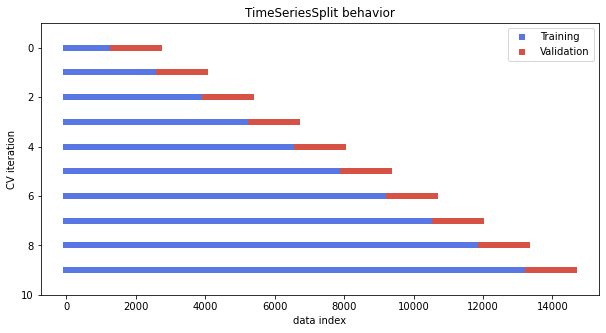

In [87]:
cv = TimeSeriesSplit(n_splits=10)
fig, ax = plt.subplots(figsize=(10, 5))
for ii, (tr, tt) in enumerate(cv.split(X_train, y_train)):
# Plot training and test indices
    l1 = ax.scatter(tr, [ii] * len(tr), c=[plt.cm.coolwarm(.1)], marker='_', lw=6)
    l2 = ax.scatter(tt, [ii] * len(tt), c=[plt.cm.coolwarm(.9)], marker='_', lw=6)
    ax.set(ylim=[10,-1],title='TimeSeriesSplit behavior', xlabel='data index', ylabel='CV iteration')
    ax.legend([l1, l2], ['Training','Validation'])



In [91]:
# Grab the date of the first index of each validation set
cv_index = [X_train.index[tt[0]] for tr, tt in cv.split(X_train, y_train)]

In [98]:
val_score = pd.DataFrame()

def score_fcn(est, X, y):
    """Return MSE between model predictions and a validation set."""
    y_predict = est.predict(X)
    MSE = mean_squared_error(y, y_predict)
    return MSE

for i in [500, 1000, 1500, 2000]:
    regression_model_rbf = SVR(kernel='rbf', C=i)
    cv_scores = cross_val_score(regression_model_rbf, X_train, y_train, cv=cv, scoring=score_fcn)
    cv_scores = pd.Series(cv_scores, index=cv_index)
    val_score['Cost='+str(i)] = cv_scores

[Text(0.5, 1.0, 'Validation data')]

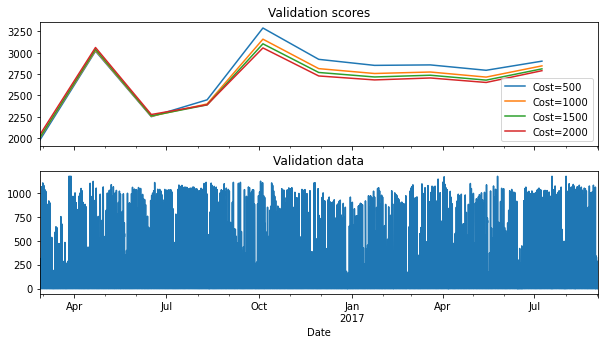

In [99]:
fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
# Calculate a rolling mean of scores over time
val_score_mean = val_score.rolling(10, min_periods=1).mean()
val_score_mean.plot(ax=axs[0])
axs[0].set(title='Validation scores')
# Plot the raw data
y_train[cv_index[0]:].plot(ax=axs[1])
axs[1].set(title='Validation data')


In [101]:
print(val_score)
print(val_score_mean)

                        Cost=500    Cost=1000    Cost=1500    Cost=2000
2016-02-26 12:00:00  1973.559699  2000.121580  2003.685727  2035.585636
2016-04-21 20:00:00  4064.230029  4057.762440  4075.829073  4087.590905
2016-06-16 04:00:00   714.784046   709.400840   702.209461   705.085987
2016-08-10 12:00:00  3040.558861  2833.206996  2773.821423  2733.749823
2016-10-04 20:00:00  6656.871707  6195.752882  5968.862218  5721.243492
2016-11-29 04:00:00  1086.714160  1087.104477  1089.149545  1084.925986
2017-01-23 12:00:00  2428.421386  2414.726373  2399.741622  2403.725869
2017-03-19 20:00:00  2895.555360  2895.946707  2879.603374  2862.592314
2017-05-14 04:00:00  2290.386273  2238.485524  2219.771251  2232.184112
2017-07-08 12:00:00  3864.757420  4031.072491  4000.794476  4031.256359
                        Cost=500    Cost=1000    Cost=1500    Cost=2000
2016-02-26 12:00:00  1973.559699  2000.121580  2003.685727  2035.585636
2016-04-21 20:00:00  3018.894864  3028.942010  3039.757400  3061

In [ ]:
regression_model_rbf.fit(X_train, y_train)
y_predict_rbf = regression_model_rbf.predict(X_test)
print(mean_squared_error(y_test,y_predict_rbf))

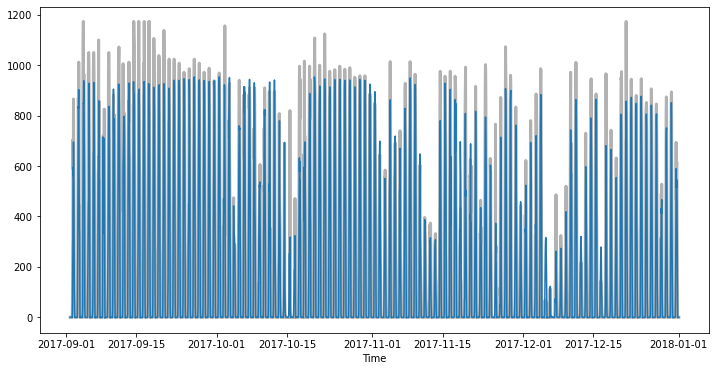

In [35]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(y_test, color='k', alpha=.3, lw=3)
ax.plot(y_test.index, y_predict_rbf)
ax.set(xlabel="Time")
plt.show()
